# Sheet 3: Verification if SED MRF results

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import copy
import importlib

import binary_hopfield as sim
import Ising_Model as im
import SED_utility as util

from pathlib import Path

this_folder = Path.cwd()
sed_data_folder = Path(Path.cwd()/'SED_DATA')
plots_folder = Path(Path.cwd()/'PLOTS')
results_folder = Path(Path.cwd()/'CALIB_RESULTS')


In [3]:
importlib.reload(util)
XB,XUK,survey_nodes = util.load_maps(this_folder)
XUK = XUK/1000
XB = XB/1000

In [4]:
importlib.reload(util)
files = os.listdir(sed_data_folder)
num_files = len(files)
print('num files = ', num_files)

#Get SED locations and distance matrix
df0 = util.get_SED_df(sed_data_folder,files[0])
L = df0['x'].values.shape[0]
XS = np.array([df0['x'].values,df0['y'].values]).T
dmat_SED = distance_matrix(XS,XS)

#Adjacency matrix for Moran I
importlib.reload(util)
num_nbrs = 6
AI = util.make_Adj(XS,num_nbrs)

num files =  68


In [5]:
epsilon=10
df_bc = pd.read_csv('neutral_N5_b_c_epsilon_{}.csv'.format(epsilon))
b_vals = df_bc['b'].values
c_vals = df_bc['c'].values
print(df_bc)

df_mu = pd.read_csv('interface_mu_vals.csv'.format(epsilon))
mu_vals = df_mu['mu'].values
print(df_mu)

importlib.reload(util)
potts_thetas = []
potts_lnZs = []
for mu in mu_vals:
    theta = util.load_matrix(results_folder,'THETA_Potts',mu)
    potts_thetas.append(theta)
    lnZ = util.load_matrix(results_folder,'lnZ_Potts',mu)
    potts_lnZs.append(lnZ[0,0])
    
neut_thetas = []
neut_lnZs = []
for b in b_vals:
    theta = util.load_matrix(results_folder,'THETA_Neutral',b)
    neut_thetas.append(theta)
    lnZ = util.load_matrix(results_folder,'lnZ_Neutral',b)
    neut_lnZs.append(lnZ[0,0])

       b         c
0  0.700 -0.074335
1  0.775 -0.068363
2  0.850 -0.055646
3  0.925 -0.029178
4  0.990 -0.005259
    mu
0   50
1  100
2  150
3  200
4  300
THETA_Potts_param_50.000.csv  loaded. 
lnZ_Potts_param_50.000.csv  loaded. 
THETA_Potts_param_100.000.csv  loaded. 
lnZ_Potts_param_100.000.csv  loaded. 
THETA_Potts_param_150.000.csv  loaded. 
lnZ_Potts_param_150.000.csv  loaded. 
THETA_Potts_param_200.000.csv  loaded. 
lnZ_Potts_param_200.000.csv  loaded. 
THETA_Potts_param_300.000.csv  loaded. 
lnZ_Potts_param_300.000.csv  loaded. 
THETA_Neutral_param_0.700.csv  loaded. 
lnZ_Neutral_param_0.700.csv  loaded. 
THETA_Neutral_param_0.775.csv  loaded. 
lnZ_Neutral_param_0.775.csv  loaded. 
THETA_Neutral_param_0.850.csv  loaded. 
lnZ_Neutral_param_0.850.csv  loaded. 
THETA_Neutral_param_0.925.csv  loaded. 
lnZ_Neutral_param_0.925.csv  loaded. 
THETA_Neutral_param_0.990.csv  loaded. 
lnZ_Neutral_param_0.990.csv  loaded. 


In [12]:
importlib.reload(im)
importlib.reload(util)

#Generate samples (using MRF with interactions theta) and their corresponding Moran I values
def generate_samples(theta,AI,ncop,loops):
    Is=[]  
    samples=[]

    sys = im.ising(theta,ncop)
    for i in range(loops):
        sys.update()

    for states in sys.states:
        samples.append(states)
        I = util.moran_I(states,AI)
        Is.append(I)
    return samples, Is


In [13]:
importlib.reload(im)
mean_lnP_curves=[]
for k in range(5):
    ncop=100
    loops=20000
    potts_samples,neut_Is = generate_samples(potts_thetas[k],AI,ncop,loops)
    potts_lnP_means = []
    
    for theta, lnZ in zip(potts_thetas,potts_lnZs):
        lnPs=[]
        for state in potts_samples:
            lnP = im.lnP(state,theta,lnZ)
            lnPs.append(lnP)
        lnP_bar=np.mean(lnPs)
        potts_lnP_means.append(lnP_bar)
    mean_lnP_curves.append(potts_lnP_means)

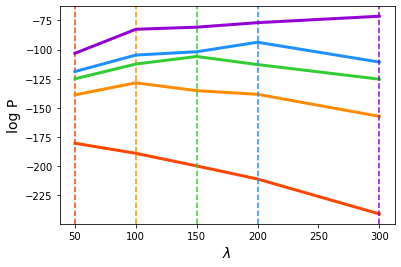

In [14]:
cols = ['orangered','darkorange','limegreen','dodgerblue','darkviolet']

for curve,col,mu in zip(mean_lnP_curves,cols,mu_vals):
    #curve = curve-max(curve)
    plt.plot(mu_vals,curve,c=col,linewidth=3)
    plt.axvline(mu,c=col,linestyle='--')
    

#plt.ylim(-20,1)
plt.xlabel('$\lambda$',size=14)
plt.ylabel('log P',size=14)
plt.show()

In [15]:
importlib.reload(im)
neut_mean_lnP_curves=[]
for k in range(5):
    ncop=100
    loops=20000
    neut_samples,neut_Is = generate_samples(neut_thetas[k],AI,ncop,loops)
    neut_lnP_means = []
    
    for theta, lnZ in zip(neut_thetas,neut_lnZs):
        lnPs=[]
        for state in neut_samples:
            lnP = im.lnP(state,theta,lnZ)
            lnPs.append(lnP)
        lnP_bar=np.mean(lnPs)
        neut_lnP_means.append(lnP_bar)
    neut_mean_lnP_curves.append(neut_lnP_means)

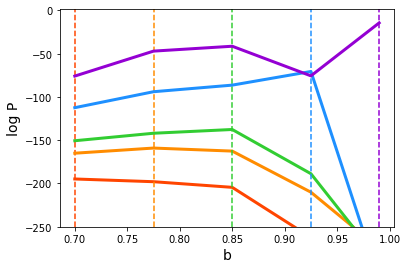

In [16]:
cols = ['orangered','darkorange','limegreen','dodgerblue','darkviolet']

for curve,col,b in zip(neut_mean_lnP_curves,cols,b_vals):
    #curve = curve-max(curve)
    plt.plot(b_vals,curve,c=col,linewidth=3)
    plt.axvline(b,c=col,linestyle='--')
    

plt.ylim(-250,1)
plt.xlabel('b',size=14)
plt.ylabel('log P',size=14)
plt.show()

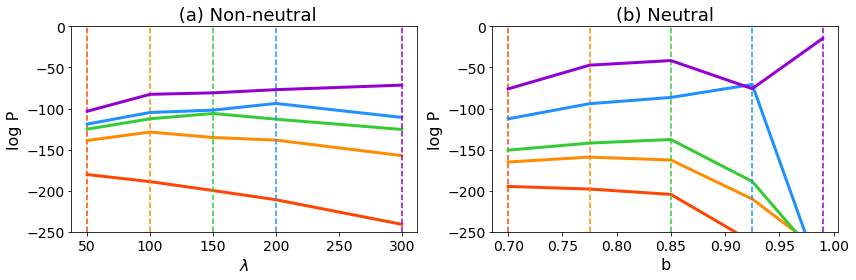

In [17]:
fig, axs = plt.subplots(1, 2,figsize=(12,4))

for curve,col,mu in zip(mean_lnP_curves,cols,mu_vals):
    #curve = curve-max(curve)
    axs[0].plot(mu_vals,curve,c=col,linewidth=3)
    axs[0].axvline(mu,c=col,linestyle='--')

axs[0].tick_params(labelsize=14)
axs[0].set_ylim(-250,0)
axs[0].set_xlabel('$\lambda$',size=16)
axs[0].set_ylabel('log P',size=16)
axs[0].set_title(' (a) Non-neutral',size=18)

for curve,col,mu in zip(neut_mean_lnP_curves,cols,b_vals):
    #curve = curve-max(curve)
    axs[1].plot(b_vals,curve,c=col,linewidth=3)
    axs[1].axvline(mu,c=col,linestyle='--')
    
axs[1].tick_params(labelsize=14)
axs[1].set_ylim(-250,0)
axs[1].set_xlabel('b',size=16)
axs[1].set_ylabel('log P',size=16)
axs[1].set_title('(b) Neutral',size=18)

plt.tight_layout()
plt.savefig(plots_folder/'Likelihoods.pdf',dpi=400)


# Illustrative plots

In [19]:
# Create illustrative plot showing results of each theta matrix
plot_samples = []
plot_titles = []
ncop=2
loops=20000
for mu,theta in zip(mu_vals,potts_thetas):
    samples,Is = generate_samples(theta,AI,ncop,loops)
    for samp,I in zip(samples,Is):
        plot_samples.append(samp)
        plot_titles.append('Non-neutral $\lambda$ = {} \n Moran I = {}'.format(mu,np.round(I,2)))
        
for b,theta in zip(b_vals,neut_thetas):
    samples,Is = generate_samples(theta,AI,ncop,loops)
    for samp,I in zip(samples,Is):
        plot_samples.append(samp)
        plot_titles.append('Neutral b = {} \n Moran I = {}'.format(b,np.round(I,2)))

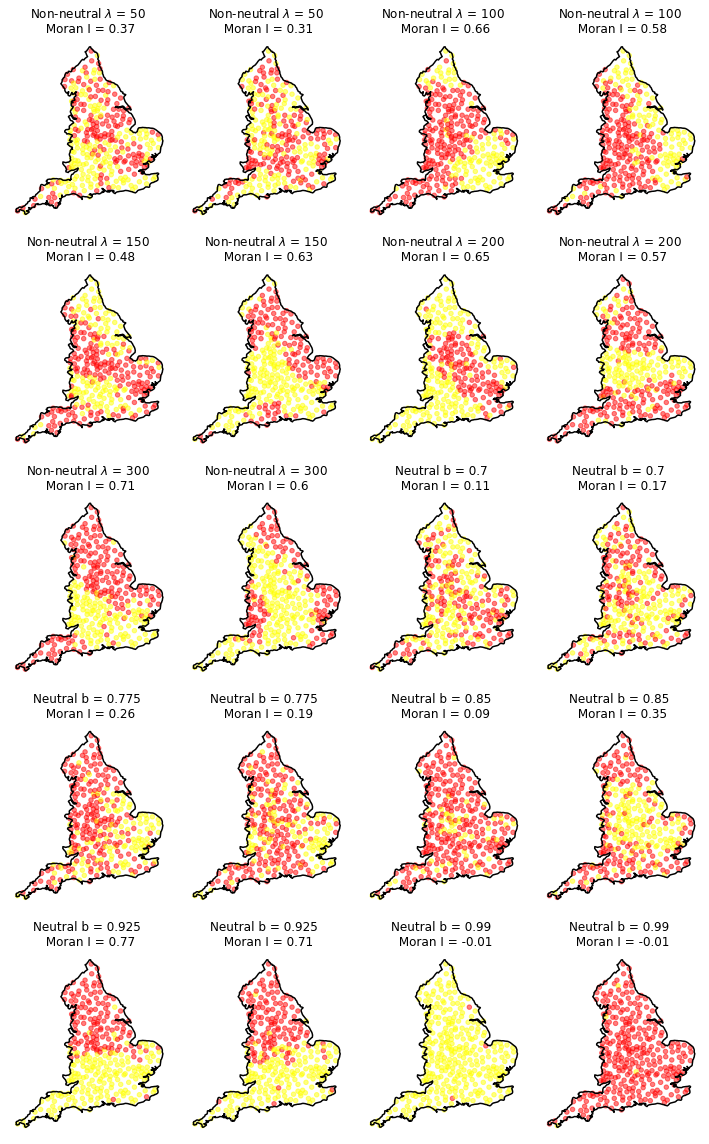

In [20]:
rows=5
cols=4
k=0
fig, axs = plt.subplots(rows, cols,figsize=(2.5*cols,3.2*rows))
for i in range(rows):
    for j in range(cols):
        states = plot_samples[k]
        axs[i,j].plot(XB[:,0],XB[:,1],'k',rasterized=True)
        axs[i,j].scatter(XS[:,0],XS[:,1],c=states,cmap='autumn',s=20,alpha=0.5,rasterized=True)
        title = plot_titles[k]
        axs[i,j].set_title(title,size=12)
        axs[i,j].axis('off')
        k += 1
plt.tight_layout()
plt.savefig(plots_folder/'MRF_samples.pdf',dpi=400)